### 1. 创建模拟数据集

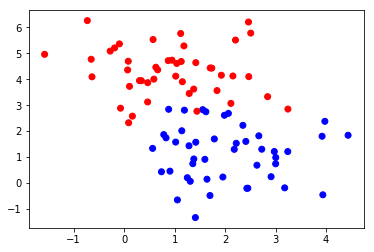

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs

# generate 2d classification dataset
X, Y = make_blobs(n_samples=90, centers=2, n_features=2, random_state=0)
# Y = Y.reshape(-1, 1)

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(X[:,0], X[:,1], c=[colors[i] for i in Y])

plt.show()

### 2. spark 读取 numpy 数据

In [27]:
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

df = np.concatenate((Y.reshape(-1,1), X), axis=1)
dff = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), df)

training = spark.createDataFrame(dff, schema=["label", "features"])

training.show(5, truncate=False)

+-----+----------------------------------------+
|label|features                                |
+-----+----------------------------------------+
|1    |[2.6693468917789582,1.8198703315044638] |
|1    |[1.0550521740433132,-0.6471074368396748]|
|1    |[0.5640099287272724,1.3370553612024738] |
|1    |[2.7275622784453133,1.3051254961790473] |
|0    |[3.2460247025341027,2.8494216528496255] |
+-----+----------------------------------------+
only showing top 5 rows



### 3. spark logistic regression

#### 3.1 模型创建

In [72]:
# regParam 正则项参数(相当于 λ)
lr = LogisticRegression(maxIter=200, regParam=0.01, elasticNetParam=0.8) 

lrModel = lr.fit(training)

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))


Coefficients: [0.47282885762546734,-2.2916297282434432]
Intercept: 5.595001120418728


#### 3.2 训练误差

In [67]:
prediction = lrModel.transform(training)
tran_error = prediction.select("label", "prediction").toPandas()  
tran_error.head()

,label,prediction
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,0,0.0


In [84]:
# 训练精度
tran_error.apply(lambda x: x["label"] == x["prediction"], axis=1).values.sum() / len(Y)

0.9333333333333333

### 4. 分界线展现

[(-5, 5), Text(0, 0.5, '$X_2$'), (-5, 5), Text(0.5, 0, '$X_1$'), None]

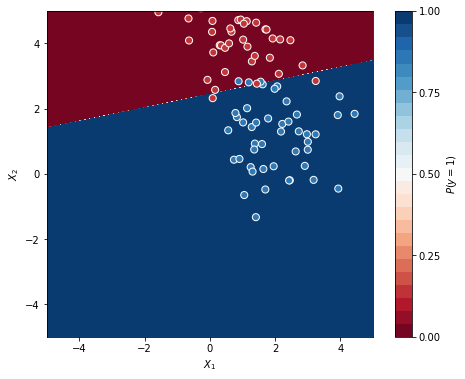

In [85]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01] 
grid = np.c_[xx.ravel(), yy.ravel()] 

test_dff = map(lambda x: (0, Vectors.dense(x)), grid) 
test_training = spark.createDataFrame(test_dff, schema=["label", "features"]) 
test_prediction = lrModel.transform(test_training) 

probs = test_prediction.select("prediction").toPandas().values 
probs = probs.reshape(xx.shape) 

f, ax = plt.subplots(figsize=(8, 6)) 
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1) 
ax_c = f.colorbar(contour) 
ax_c.set_label("$P(y = 1)$") 
ax_c.set_ticks([0, .25, .5, .75, 1]) 

ax.scatter(X[:,0], X[:, 1], c=Y, s=50, 
           cmap="RdBu", vmin=-.2, vmax=1.2, 
           edgecolor="white", linewidth=1) 

ax.set(aspect="equal", 
       xlim=(-5, 5), ylim=(-5, 5), 
       xlabel="$X_1$", ylabel="$X_2$") 